In [1]:
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/terracotta")
import terracotta as tct
import importlib
importlib.reload(tct)
sys.path.append("/Users/jameskitchens/Documents/GitHub/tskit_arg_visualizer")
import tskit_arg_visualizer as tsviz
importlib.reload(tsviz)
import pandas as pd
import tskit
import numpy as np
import matplotlib.pyplot as plt

/opt/anaconda3/envs/terracotta/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Confirming that results match expectations for small ARG

In [2]:
import numpy as np
from scipy import linalg
from scipy.special import logsumexp

In [3]:
tables = tskit.TableCollection(sequence_length=1e3)

node_table = tables.nodes
node_table.add_row(flags=tskit.NODE_IS_SAMPLE, time=0)
node_table.add_row(flags=tskit.NODE_IS_SAMPLE, time=0)
node_table.add_row(time=1)
node_table.add_row(time=2)
node_table.add_row(time=3)

edge_table = tables.edges
edge_table.set_columns(
    left=np.array([0, 0, 0, 500, 500]),
    right=np.array([1e3, 1e3, 500, 1e3, 1e3]),
    parent=np.array([2, 3, 3, 4, 4], dtype=np.int32),  # References IDs in the node table
    child=np.array([0, 1, 2, 2, 3], dtype=np.int32),  # References IDs in the node table
)

g = tables.tree_sequence()
d3arg = tsviz.D3ARG.from_ts(g)
d3arg.draw()

In [4]:
# In natural space
Q = np.array([[-0.1, 0.1],[0.1, -0.1]])
M02 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*1))
M13 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*2))

## If 2 is in deme 0
N2_0_M23 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*1))
N2_0_M24 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*2))
N2_0_M34 = np.matmul(np.multiply(M13, N2_0_M23), linalg.expm(Q*1))
N2_0_N4 = np.multiply(N2_0_M24, N2_0_M34)
N2_0_rootlike = np.sum(N2_0_N4)

## If 2 is in deme 1
N2_1_M23 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*1))
N2_1_M24 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*2))
N2_1_M34 = np.matmul(np.multiply(M13, N2_1_M23), linalg.expm(Q*1))
N2_1_N4 = np.multiply(N2_1_M24, N2_1_M34)
N2_1_rootlike = np.sum(N2_1_N4)

nat_total = N2_0_rootlike * M02[0][0] + N2_1_rootlike * M02[0][1]
print("Natural ARG Likelihood:", nat_total)
print("Log of Natural ARG Likelihood:", np.log(nat_total))


# In log space
Q = np.array([[-0.1, 0.1],[0.1, -0.1]])
M02 = np.log(np.matmul(np.array([[1, 0]]), linalg.expm(Q*1)))
M13 = np.log(np.matmul(np.array([[0, 1]]), linalg.expm(Q*2)))

## If 2 is in deme 0
N2_0_M23 = np.log(np.matmul(np.array([[1, 0]]), linalg.expm(Q*1)))
N2_0_M24 = np.log(np.matmul(np.array([[1, 0]]), linalg.expm(Q*2)))
N2_0_M34 = np.array([logsumexp(np.log(linalg.expm(Q*1)).T + (M13 + N2_0_M23), axis=1)])
N2_0_N4 = N2_0_M24 + N2_0_M34
N2_0_rootlike = logsumexp(N2_0_N4)

## If 2 is in deme 1
N2_1_M23 = np.log(np.matmul(np.array([[0, 1]]), linalg.expm(Q*1)))
N2_1_M24 = np.log(np.matmul(np.array([[0, 1]]), linalg.expm(Q*2)))
N2_1_M34 = np.array([logsumexp(np.log(linalg.expm(Q*1)).T + (M13 + N2_1_M23), axis=1)])
N2_1_N4 = N2_1_M24 + N2_1_M34
N2_1_rootlike = logsumexp(N2_1_N4)

log_total = logsumexp([N2_0_rootlike + M02[0][0], N2_1_rootlike + M02[0][1]])
print("Log ARG Likelihood:", log_total)

Natural ARG Likelihood: 0.1747014470219495
Log of Natural ARG Likelihood: -1.7446767789803244
Log ARG Likelihood: -1.7446767789803248


In [5]:
g.dump("tests/arg0/arg0.trees")

with open("tests/arg0/demes.tsv", "w") as demes:
    demes.write("id\txcoord\tycoord\ttype\tneighbours\n")
    demes.write("0\t0\t0\t0\t1\n")
    demes.write("1\t1\t0\t0\t0\n")

with open("tests/arg0/samples.tsv", "w") as samples:
    samples.write("id\tdeme\n")
    samples.write("0\t0\n")
    samples.write("1\t1\n")

demes = pd.read_csv("tests/arg0/demes.tsv", sep="\t")
world_map = tct.WorldMap(demes)
ts = tskit.load("tests/arg0/arg0.trees")
sample_locations = pd.read_csv("tests/arg0/samples.tsv", sep="\t")
sample_location_vectors = world_map.build_sample_location_vectors(sample_locations=sample_locations)

print(tct.calc_generalized_migration_rate_log_likelihood(
    world_map=world_map,
    trees=[ts],
    sample_location_vectors=sample_location_vectors,
    migration_rates={0:0.1}
))

(np.float64(-1.7446767789803248), [np.float64(-1.7446767789803248)])


In [6]:
tables = tskit.TableCollection(sequence_length=1e3)

node_table = tables.nodes
node_table.add_row(flags=tskit.NODE_IS_SAMPLE, time=0)
node_table.add_row(flags=tskit.NODE_IS_SAMPLE, time=0)
node_table.add_row(time=1)
node_table.add_row(time=2)

edge_table = tables.edges
edge_table.set_columns(
    left=np.array([0, 0, 500, 500]),
    right=np.array([500, 1e3, 1e3, 1e3]),
    parent=np.array([2, 2, 3, 3], dtype=np.int32),  # References IDs in the node table
    child=np.array([0, 1, 0, 2], dtype=np.int32),  # References IDs in the node table
)

g = tables.tree_sequence()
d3arg = tsviz.D3ARG.from_ts(g)
d3arg.draw()

In [7]:
# In natural space
Q = np.array([[-0.1, 0.1],[0.1, -0.1]])
M02 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*1))
M03 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*2))
M12 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*1))
M23 = np.matmul(np.multiply(M02, M12), linalg.expm(Q*1))
N3 = np.multiply(M03, M23)
nat_total = np.sum(N3)

print("Natural ARG Likelihood:", nat_total)
print("Log of Natural ARG Likelihood:", np.log(nat_total))

# In log space
Q = np.array([[-0.1, 0.1],[0.1, -0.1]])
M02 = np.log(np.matmul(np.array([[1, 0]]), linalg.expm(Q*1)))
M03 = np.log(np.matmul(np.array([[1, 0]]), linalg.expm(Q*2)))
M12 = np.log(np.matmul(np.array([[0, 1]]), linalg.expm(Q*1)))
M23 = np.array([logsumexp(np.log(linalg.expm(Q*1)).T + (M02 + M12), axis=1)])
N3 = M03 + M23
log_total = logsumexp(N3)

print("Log ARG Likelihood:", log_total)

Natural ARG Likelihood: 0.08241998849109017
Log of Natural ARG Likelihood: -2.495927292708819
Log ARG Likelihood: -2.495927292708818


In [8]:
g.dump("tests/arg1/arg1.trees")

with open("tests/arg1/demes.tsv", "w") as demes:
    demes.write("id\txcoord\tycoord\ttype\tneighbours\n")
    demes.write("0\t0\t0\t0\t1\n")
    demes.write("1\t1\t0\t0\t0\n")

with open("tests/arg1/samples.tsv", "w") as samples:
    samples.write("id\tdeme\n")
    samples.write("0\t0\n")
    samples.write("1\t1\n")

demes = pd.read_csv("tests/arg1/demes.tsv", sep="\t")
world_map = tct.WorldMap(demes)
ts = tskit.load("tests/arg1/arg1.trees")
sample_locations = pd.read_csv("tests/arg1/samples.tsv", sep="\t")
sample_location_vectors = world_map.build_sample_location_vectors(sample_locations=sample_locations)

print(tct.calc_generalized_migration_rate_log_likelihood(
    world_map=world_map,
    trees=[ts],
    sample_location_vectors=sample_location_vectors,
    migration_rates={0:0.1}
))

(np.float64(-2.495927292708818), [np.float64(-2.495927292708818)])


In [9]:
tables = tskit.TableCollection(sequence_length=1e3)

node_table = tables.nodes
node_table.add_row(flags=tskit.NODE_IS_SAMPLE, time=0)
node_table.add_row(flags=tskit.NODE_IS_SAMPLE, time=0)
node_table.add_row(flags=tskit.NODE_IS_SAMPLE, time=0)
node_table.add_row(flags=tskit.NODE_IS_SAMPLE, time=0)
node_table.add_row(flags=tskit.NODE_IS_SAMPLE, time=0)
node_table.add_row(time=1)
node_table.add_row(time=2)
node_table.add_row(time=3)
node_table.add_row(time=4)
node_table.add_row(time=5)

edge_table = tables.edges
edge_table.set_columns(
    left=np.array([0, 0, 0, 0, 0, 0, 0, 500, 500, 750, 750]),
    right=np.array([1e3, 1e3, 1e3, 1e3, 1e3, 750, 500, 1e3, 750, 1e3, 1e3]),
    parent=np.array([5, 5, 6, 6, 6, 7, 7, 8, 8, 9, 9], dtype=np.int32),  # References IDs in the node table
    child=np.array([3, 4, 0, 1, 2, 5, 6, 6, 7, 5, 8], dtype=np.int32),  # References IDs in the node table
)

g = tables.tree_sequence()
d3arg = tsviz.D3ARG.from_ts(g)
d3arg.draw()

In [10]:
# In natural space
Q = np.array([[-0.1, 0.1],[0.1, -0.1]])
M06 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*2))
M16 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*2))
M26 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*2))
M35 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*1))
M45 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*1))
N5 = np.multiply(M35, M45)
N6 = np.multiply(np.multiply(M06, M16), M26)

## If 5 is in deme 0 and 6 is in deme 0
M57 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*2))
M59 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*4))
M67 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*1))
M68 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*2))
M78 = np.matmul(np.multiply(M57, M67), linalg.expm(Q*1))
M89 = np.matmul(np.multiply(M68, M78), linalg.expm(Q*1))
N9 = np.multiply(M59, M89)
N9_00_rootlike = np.sum(N9)

## If 5 is in deme 0 and 6 is in deme 1
M57 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*2))
M59 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*4))
M67 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*1))
M68 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*2))
M78 = np.matmul(np.multiply(M57, M67), linalg.expm(Q*1))
M89 = np.matmul(np.multiply(M68, M78), linalg.expm(Q*1))
N9 = np.multiply(M59, M89)
N9_01_rootlike = np.sum(N9)

## If 5 is in deme 1 and 6 is in deme 0
M57 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*2))
M59 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*4))
M67 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*1))
M68 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*2))
M78 = np.matmul(np.multiply(M57, M67), linalg.expm(Q*1))
M89 = np.matmul(np.multiply(M68, M78), linalg.expm(Q*1))
N9 = np.multiply(M59, M89)
N9_10_rootlike = np.sum(N9)

## If 5 is in deme 1 and 6 is in deme 1
M57 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*2))
M59 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*4))
M67 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*1))
M68 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*2))
M78 = np.matmul(np.multiply(M57, M67), linalg.expm(Q*1))
M89 = np.matmul(np.multiply(M68, M78), linalg.expm(Q*1))
N9 = np.multiply(M59, M89)
N9_11_rootlike = np.sum(N9)

nat_total = (N9_00_rootlike * N5[0][0] * N6[0][0]) + (N9_01_rootlike * N5[0][0] * N6[0][1]) + (N9_10_rootlike * N5[0][1] * N6[0][0]) + (N9_11_rootlike * N5[0][1] * N6[0][1])

print("Natural ARG Likelihood:", nat_total)
print("Log of Natural ARG Likelihood:", np.log(nat_total))

Natural ARG Likelihood: 0.00506783647813304
Log of Natural ARG Likelihood: -5.284841282605541


In [11]:
g.dump("tests/arg2/arg2.trees")

with open("tests/arg2/demes.tsv", "w") as demes:
    demes.write("id\txcoord\tycoord\ttype\tneighbours\n")
    demes.write("0\t0\t0\t0\t1\n")
    demes.write("1\t1\t0\t0\t0\n")

with open("tests/arg2/samples.tsv", "w") as samples:
    samples.write("id\tdeme\n")
    samples.write("0\t0\n")
    samples.write("1\t1\n")
    samples.write("2\t0\n")
    samples.write("3\t1\n")
    samples.write("4\t0\n")

demes = pd.read_csv("tests/arg2/demes.tsv", sep="\t")
world_map = tct.WorldMap(demes)
ts = tskit.load("tests/arg2/arg2.trees")
sample_locations = pd.read_csv("tests/arg2/samples.tsv", sep="\t")
sample_location_vectors = world_map.build_sample_location_vectors(sample_locations=sample_locations)

print(tct.calc_generalized_migration_rate_log_likelihood(
    world_map=world_map,
    trees=[ts],
    sample_location_vectors=sample_location_vectors,
    migration_rates={0:0.1}
))

(np.float64(-5.284841282605541), [np.float64(-5.284841282605541)])


In [12]:
tables = tskit.TableCollection(sequence_length=1e3)

node_table = tables.nodes
node_table.add_row(flags=tskit.NODE_IS_SAMPLE, time=0)
node_table.add_row(flags=tskit.NODE_IS_SAMPLE, time=0)
node_table.add_row(flags=tskit.NODE_IS_SAMPLE, time=0)
node_table.add_row(flags=tskit.NODE_IS_SAMPLE, time=0)
node_table.add_row(flags=tskit.NODE_IS_SAMPLE, time=0)
node_table.add_row(time=1)
node_table.add_row(time=2)
node_table.add_row(time=3)
node_table.add_row(time=4)
node_table.add_row(time=5)

edge_table = tables.edges
edge_table.set_columns(
    left=np.array([0, 0, 0, 0, 0, 0, 500, 0, 0, 750, 750]),
    right=np.array([1e3, 1e3, 1e3, 1e3, 1e3, 750, 1e3, 500, 500, 1e3, 1e3]),
    parent=np.array([5, 5, 6, 6, 6, 7, 7, 8, 8, 9, 9], dtype=np.int32),  # References IDs in the node table
    child=np.array([3, 4, 0, 1, 2, 5, 6, 6, 7, 5, 7], dtype=np.int32),  # References IDs in the node table
)

g = tables.tree_sequence()
d3arg = tsviz.D3ARG.from_ts(g)
d3arg.draw()

In [13]:
# In natural space
Q = np.array([[-0.1, 0.1],[0.1, -0.1]])
M06 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*2))
M16 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*2))
M26 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*2))
M35 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*1))
M45 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*1))
N5 = np.multiply(M35, M45)
N6 = np.multiply(np.multiply(M06, M16), M26)

## If 5 is in deme 0 and 6 is in deme 0
M57 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*2))
M59 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*4))
M67 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*1))
M68 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*2))
M78 = np.matmul(np.multiply(M57, M67), linalg.expm(Q*1))
M89 = np.matmul(np.multiply(M68, M78), linalg.expm(Q*1))
N9 = np.multiply(M59, M89)
N9_00_rootlike = np.sum(N9)

## If 5 is in deme 0 and 6 is in deme 1
M57 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*2))
M59 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*4))
M67 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*1))
M68 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*2))
M78 = np.matmul(np.multiply(M57, M67), linalg.expm(Q*1))
M89 = np.matmul(np.multiply(M68, M78), linalg.expm(Q*1))
N9 = np.multiply(M59, M89)
N9_01_rootlike = np.sum(N9)

## If 5 is in deme 1 and 6 is in deme 0
M57 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*2))
M59 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*4))
M67 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*1))
M68 = np.matmul(np.array([[1, 0]]), linalg.expm(Q*2))
M78 = np.matmul(np.multiply(M57, M67), linalg.expm(Q*1))
M89 = np.matmul(np.multiply(M68, M78), linalg.expm(Q*1))
N9 = np.multiply(M59, M89)
N9_10_rootlike = np.sum(N9)

## If 5 is in deme 1 and 6 is in deme 1
M57 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*2))
M59 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*4))
M67 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*1))
M68 = np.matmul(np.array([[0, 1]]), linalg.expm(Q*2))
M78 = np.matmul(np.multiply(M57, M67), linalg.expm(Q*1))
M89 = np.matmul(np.multiply(M68, M78), linalg.expm(Q*1))
N9 = np.multiply(M59, M89)
N9_11_rootlike = np.sum(N9)

nat_total = (N9_00_rootlike * N5[0][0] * N6[0][0]) + (N9_01_rootlike * N5[0][0] * N6[0][1]) + (N9_10_rootlike * N5[0][1] * N6[0][0]) + (N9_11_rootlike * N5[0][1] * N6[0][1])

print("Natural ARG Likelihood:", nat_total)
print("Log of Natural ARG Likelihood:", np.log(nat_total))

Natural ARG Likelihood: 0.00506783647813304
Log of Natural ARG Likelihood: -5.284841282605541


In [14]:
g.dump("tests/arg3/arg3.trees")

with open("tests/arg3/demes.tsv", "w") as demes:
    demes.write("id\txcoord\tycoord\ttype\tneighbours\n")
    demes.write("0\t0\t0\t0\t1\n")
    demes.write("1\t1\t0\t0\t0\n")

with open("tests/arg3/samples.tsv", "w") as samples:
    samples.write("id\tdeme\n")
    samples.write("0\t0\n")
    samples.write("1\t1\n")
    samples.write("2\t0\n")
    samples.write("3\t1\n")
    samples.write("4\t0\n")

demes = pd.read_csv("tests/arg3/demes.tsv", sep="\t")
world_map = tct.WorldMap(demes)
ts = tskit.load("tests/arg3/arg3.trees")
sample_locations = pd.read_csv("tests/arg3/samples.tsv", sep="\t")
sample_location_vectors = world_map.build_sample_location_vectors(sample_locations=sample_locations)

print(tct.calc_generalized_migration_rate_log_likelihood(
    world_map=world_map,
    trees=[ts],
    sample_location_vectors=sample_location_vectors,
    migration_rates={0:0.1}
))

(np.float64(-5.310132287301459), [np.float64(-5.310132287301459)])


## Running

In [71]:
demes = pd.read_csv("migration_rate_scan/demes.tsv", sep="\t")
world_map = tct.WorldMap(demes)

tct.create_samples_and_arg_files(
    demes_path="migration_rate_scan/demes.tsv",
    number_of_samples=100,
    sequence_length=125_000,
    recombination_rate=1e-8,
    ploidy=1,
    allow_multiple_samples_per_deme=True,
    pop_size=500,
    migration_rate=0.01,
    output_directory="migration_rate_scan/arg2"
)

In [17]:
def simplify_with_recombination(ts, flag_recomb=False, keep_nodes=None):
    """Simplifies a tree sequence while keeping recombination nodes

    Removes unary nodes that are not recombination nodes. Does not remove non-genetic ancestors.
    Edges intervals are not updated. This differs from how tskit's TreeSequence.simplify() works.

    Parameters
    ----------
    ts : tskit.TreeSequence
    flag_recomb (optional) : bool
        Whether to add msprime node flags. Default is False.
    keep_nodes (optional) : list
        List of node IDs that should be kept. Default is None, so empty list.

    Returns
    -------
    ts_sim : tskit.TreeSequence
        Simplified tree sequence
    maps_sim : numpy.ndarray
        Mapping for nodes in the simplified tree sequence versus the original
    """

    if keep_nodes == None:
        keep_nodes = []

    uniq_child_parent = np.unique(np.column_stack((ts.edges_child, ts.edges_parent)), axis=0)
    child_node, parents_count = np.unique(uniq_child_parent[:, 0], return_counts=True) #For each child, count how many parents it has.
    parent_node, children_count = np.unique(uniq_child_parent[:, 1], return_counts=True) #For each child, count how many parents it has.
    multiple_parents = child_node[parents_count > 1] #Find children who have more than 1 parent. 
    recomb_nodes = ts.edges_parent[np.isin(ts.edges_child, multiple_parents)] #Find the parent nodes of the children with multiple parents. 
    
    if flag_recomb:
        ts_tables = ts.dump_tables()
        node_table = ts_tables.nodes
        flags = node_table.flags
        flags[recomb_nodes] = 131072 #msprime.NODE_IS_RE_EVENT
        node_table.flags = flags
        ts_tables.sort() 
        ts = ts_tables.tree_sequence()
    
    keep_nodes = np.unique(np.concatenate((keep_nodes, recomb_nodes)))
    potentially_uninformative = np.intersect1d(child_node[np.where(parents_count!=0)[0]], parent_node[np.where(children_count==1)[0]])
    truly_uninformative = np.delete(potentially_uninformative, np.where(np.isin(potentially_uninformative, keep_nodes)))
    all_nodes = np.array(range(ts.num_nodes))
    important = np.delete(all_nodes, np.where(np.isin(all_nodes, truly_uninformative)))
    ts_sim, maps_sim = ts.simplify(samples=important, map_nodes=True, keep_input_roots=False, keep_unary=False, update_sample_flags=False)
    return ts_sim, maps_sim

In [20]:
ts = tskit.load("dataset/arg.trees")
print(ts)
ts, map_nodes = simplify_with_recombination(ts)
d3arg = tsviz.D3ARG.from_ts(ts)
d3arg.draw(width=2000, height=2000)

╔═══════════════════════════╗
║TreeSequence               ║
╠═══════════════╤═══════════╣
║Trees          │         18║
╟───────────────┼───────────╢
║Sequence Length│     125000║
╟───────────────┼───────────╢
║Time Units     │generations║
╟───────────────┼───────────╢
║Sample Nodes   │        100║
╟───────────────┼───────────╢
║Total Size     │   30.9 KiB║
╚═══════════════╧═══════════╝
╔═══════════╤════╤═════════╤════════════╗
║Table      │Rows│Size     │Has Metadata║
╠═══════════╪════╪═════════╪════════════╣
║Edges      │ 420│ 13.1 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Individuals│ 100│  2.8 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Migrations │   0│  8 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Mutations  │   0│ 16 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Nodes      │ 364│ 10.0 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Populations│   2│265 Bytes│         Yes║
╟───────────┼────┼────

In [23]:
sample_locations = pd.read_csv("dataset/samples.tsv", sep="\t")
sample_location_vectors = world_map.build_sample_location_vectors(sample_locations=sample_locations)

In [38]:
migration_rates = []
for m in range(3,-1,-1):
    for i in range(1,10):
        migration_rates.append(i*10**(-m))

trees_max_like = -999999
trees_max_rate = -1
by_tree = []
for m0 in migration_rates:
    ll = tct.calc_migration_rate_log_likelihood(
        world_map=world_map,
        trees=ts.trees(),
        sample_location_vectors=sample_location_vectors,
        migration_rates={0:m0}
    )
    by_tree.append(ll[1])
    if ll[0] > trees_max_like:
        trees_max_like = ll[0]
        trees_max_rate = m0
    print(m0, ll[0])
by_tree = np.array(by_tree)

0.001 -1856.4716376590707
0.002 -1578.192340531337
0.003 -1432.911750409098
0.004 -1339.9986032748184
0.005 -1274.7455856706927
0.006 -1226.4176550254106
0.007 -1189.3999434712503
0.008 -1160.384426643017
0.009000000000000001 -1137.2573984315782
0.01 -1118.5893284563524
0.02 -1043.5423965827454
0.03 -1033.3709970009115
0.04 -1036.379982727833
0.05 -1042.4397257988696
0.06 -1049.107461777889
0.07 -1055.7577946691745
0.08 -1062.2039148399592
0.09 -1068.368476628917
0.1 -1074.2110061291776
0.2 -1115.3585074593757
0.30000000000000004 -1137.0479922993643
0.4 -1150.72477539922
0.5 -1160.6027944319253
0.6000000000000001 -1168.3093767260984
0.7000000000000001 -1174.5984414402324
0.8 -1179.8784070416755
0.9 -1184.3972183534613
1 -1188.317909017956
2 -1210.0601195848471
3 -1218.7169454548755
4 -1223.4666298409606
5 -1226.5850961398269
6 -1228.7716467650753
7 -1230.3433158287128
8 -1231.4896343508492
9 -1232.3366266503162


In [39]:
print(np.argmax(by_tree, axis=0))

[11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11]


In [44]:
args = []
for bp in ts.breakpoints():
    if bp > 0:
        ts_short = ts.keep_intervals(intervals=[(0,bp)], simplify=False).trim()
        args.append(ts_short)

migration_rates = []
for m in range(3,1,-1):
    for i in range(1,10):
        migration_rates.append(i*10**(-m))

num_trees = []
max_per_arg = []
for arg in args[:10]:
    print(arg.num_trees)
    max_like = -999999
    max_rate = -1
    for m0 in [trees_max_rate + inc/1000 for inc in range(-4,5)]:
        ll = tct.calc_generalized_migration_rate_log_likelihood(
            world_map=world_map,
            trees=[arg],
            sample_location_vectors=sample_location_vectors,
            migration_rates={0:m0}
        )
        if ll[0] > max_like:
            max_like = ll[0]
            max_rate = m0
    num_trees.append(arg.num_trees)
    max_per_arg.append(max_rate)

1
2
3
4
5
6
7
8
9
10


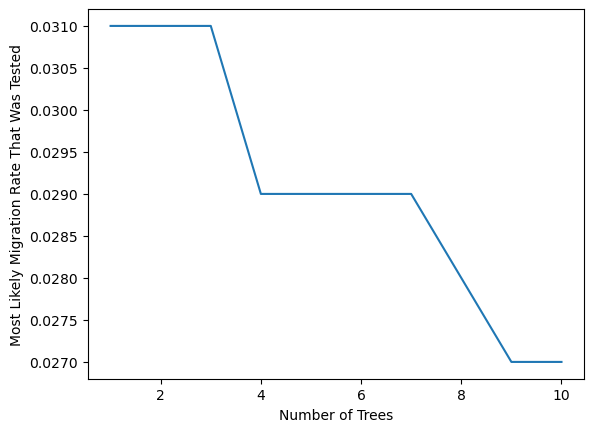

In [45]:
plt.plot(num_trees, max_per_arg)
plt.xlabel("Number of Trees")
plt.ylabel("Most Likely Migration Rate That Was Tested")
plt.show()

## Migration Rate Scan

In [75]:
output_num_trees = []
output_max_per_arg = []
output_trees_max_rate = []

for i in range(5):
    print(i)
    ts = tskit.load(f"migration_rate_scan/arg{i}/arg.trees")
    ts, map_nodes = simplify_with_recombination(ts)
    ts = ts.keep_intervals(intervals=[(0,list(ts.breakpoints())[10])], simplify=False).trim()
    sample_locations = pd.read_csv(f"migration_rate_scan/arg{i}/samples.tsv", sep="\t")
    sample_location_vectors = world_map.build_sample_location_vectors(sample_locations=sample_locations)
    
    migration_rates = []
    for m in range(3,-1,-1):
        for i in range(1,10):
            migration_rates.append(i*10**(-m))
    
    trees_max_like = -999999
    trees_max_rate = -1
    for m0 in migration_rates:
        ll = tct.calc_migration_rate_log_likelihood(
            world_map=world_map,
            trees=ts.trees(),
            sample_location_vectors=sample_location_vectors,
            migration_rates={0:m0}
        )
        if ll[0] > trees_max_like:
            trees_max_like = ll[0]
            trees_max_rate = m0
    print(trees_max_rate)
    output_trees_max_rate.append(trees_max_rate)

    args = []
    for bp in ts.breakpoints():
        if bp > 0:
            ts_short = ts.keep_intervals(intervals=[(0,bp)], simplify=False).trim()
            args.append(ts_short)

    num_trees = []
    max_per_arg = []
    for arg in args[:10]:
        print(arg.num_trees)
        max_like = -999999
        max_rate = -1
        for m0 in [trees_max_rate + inc/1000 for inc in range(-4,5)]:
            ll = tct.calc_generalized_migration_rate_log_likelihood(
                world_map=world_map,
                trees=[arg],
                sample_location_vectors=sample_location_vectors,
                migration_rates={0:m0}
            )
            if ll[0] > max_like:
                max_like = ll[0]
                max_rate = m0
        num_trees.append(arg.num_trees)
        max_per_arg.append(max_rate)

    output_num_trees.append(num_trees)
    output_max_per_arg.append(max_per_arg)

0
0.03
1
2
3
4
5
6
7
8
9
10
1
0.008
1
2
3
4
5
6
7
8
9
10
2
0.01
1
2
3
4
5
6
7
8
9
10
3
0.01
1
2
3
4
5
6
7
8
9
10
4
0.006
1
2
3
4
5
6
7
8
9
10


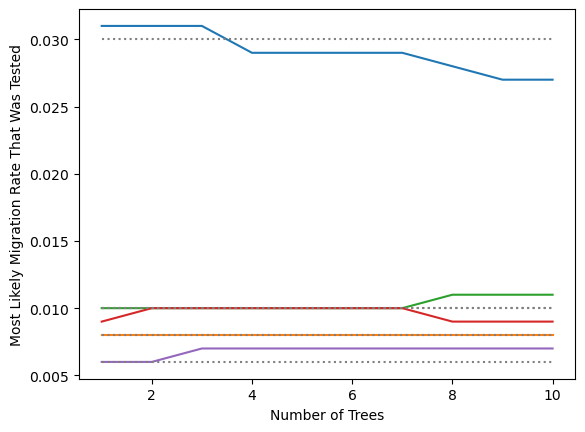

In [83]:
for i in range(5):
    plt.plot(output_num_trees[i], output_max_per_arg[i])
plt.hlines(output_trees_max_rate, 1, 10, linestyles="dotted", color="grey")
plt.xlabel("Number of Trees")
plt.ylabel("Most Likely Migration Rate That Was Tested")
plt.savefig("assets/migration_rate_scan.png")
plt.show()

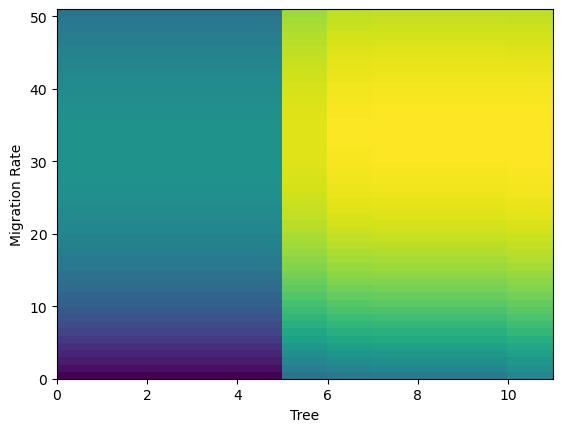

In [90]:
plt.pcolor(by_tree, linewidths=1)
plt.xlabel("Tree")
plt.ylabel("Migration Rate")
plt.show()

In [80]:
tables = tskit.TableCollection(sequence_length=1e3)

node_table = tables.nodes
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)
node_table.add_row(time=100000000)
node_table.add_row(time=200000000)
node_table.add_row(time=300000000)

edge_table = tables.edges
edge_table.set_columns(
    left=np.array([0, 0, 0, 500, 0]),
    right=np.array([1e3, 1e3, 500, 1e3, 1e3]),
    parent=np.array([2, 3, 3, 4, 4], dtype=np.int32),  # References IDs in the node table
    child=np.array([0, 1, 2, 2, 3], dtype=np.int32),  # References IDs in the node table
)

g = tables.tree_sequence()
print(g.draw_text())

300000000.00┊  4  ┊  4  ┊  
            ┊  ┃  ┊ ┏┻┓ ┊  
200000000.00┊  3  ┊ ┃ 3 ┊  
            ┊ ┏┻┓ ┊ ┃ ┃ ┊  
100000000.00┊ 2 ┃ ┊ 2 ┃ ┊  
            ┊ ┃ ┃ ┊ ┃ ┃ ┊  
0.00        ┊ 0 1 ┊ 0 1 ┊  
            0    500  1000 



In [81]:
tree0 = g.first()
tree1 = g.last()

In [82]:
migration_rates = []
for m in range(8,-1,-1):
    for i in mult:
        migration_rates.append(i*10**(-m))

In [83]:
for m0 in migration_rates:
    ll = tct.calc_migration_rate_log_likelihood(
        world_map=world_map,
        trees=[tree0],
        sample_location_vectors=sample_location_vectors,
        migration_rates={0:m0}
    )[0]
    print(ll)

-2.5261902967694976
-2.3108347222225674
-2.302585092994078
-2.302585092994017
-2.302585092996821
-2.3025850929636213
-2.302585092387564
-2.3025851046886636
-2.302585048654473


In [30]:
tables = tskit.TableCollection(sequence_length=1e3)

node_table = tables.nodes
node_table.add_row(flags=tskit.NODE_IS_SAMPLE, time=1)
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)
node_table.add_row(flags=tskit.NODE_IS_SAMPLE, time=1)
node_table.add_row(time=2)
node_table.add_row(time=3)

edge_table = tables.edges
edge_table.set_columns(
    left=np.array([0, 0, 0, 0]),
    right=np.array([1e3, 1e3, 1e3, 1e3]),
    parent=np.array([3, 3, 4, 4], dtype=np.int32),  # References IDs in the node table
    child=np.array([1, 2, 0, 3], dtype=np.int32),  # References IDs in the node table
)

gprime = tables.tree_sequence()
print(gprime.draw_text())

3.00┊   4   ┊  
    ┊ ┏━┻┓  ┊  
2.00┊ ┃  3  ┊  
    ┊ ┃ ┏┻┓ ┊  
1.00┊ 0 ┃ 2 ┊  
    ┊   ┃   ┊  
0.00┊   1   ┊  
    0     1000 



In [33]:
for i in range(10):
    sample_locations_gprime = pd.DataFrame({"id":[0,1,2], "deme":[i,6,i]})
    sample_location_vectors_gprime = world_map.build_sample_location_vectors(sample_locations=sample_locations_gprime)

In [ ]:
def convert_to_single_recomb_node_format(ts, map_nodes=False):
    """Converts a 2-RE format tskit.TreeSequence to a 1-RE format tskit.TreeSequence

    This function may muddle edges around certain structures (i.e. diamonds). Use with caution
    if this may affect your results.

    NOTE: SOMETHING IS WRONG HERE WITH ARGs and needs to be fixed!

    Parameters
    ----------
    ts : tskit.TreeSequence
    map_nodes : bool

    Returns
    -------
    tskit.TreeSequence
        In 1-RE format
    node_id_map : list
        Optional return - index of list is the new node ID and value is the old ID
    """
    recombs_to_collapse = np.where(ts.tables.nodes.flags==131072)[0][1::2]
    tables = tskit.TableCollection(sequence_length=ts.sequence_length)
    node_table = tables.nodes
    edge_table = tables.edges
    old_node_table = ts.tables.nodes
    node_id_map = []
    for i,node in enumerate(old_node_table):
        if i not in recombs_to_collapse:
            node_table.add_row(
                flags=node.flags,
                time=node.time,
                population=-1,
                individual=-1,
                metadata=node.metadata
            )
            node_id_map.append(i)
    old_edge_table = ts.tables.edges
    for edge in old_edge_table:
        c = edge.child
        p = edge.parent
        if edge.child in recombs_to_collapse:
            c -= 1
        if edge.parent in recombs_to_collapse:
            p -= 1
        edge_table.add_row(
            left=edge.left,
            right=edge.right,
            parent=p-sum(recombs_to_collapse < p),
            child=c-sum(recombs_to_collapse < c),
            metadata=edge.metadata
        ) 
    tables.sort()
    if map_nodes:
        return tables.tree_sequence(), node_id_map
    else:
        return tables.tree_sequence()